In [21]:
!pip install tensorflow==2.16.1

  Obtaining dependency information for tensorflow==2.16.1 from https://files.pythonhosted.org/packages/e4/14/d795bb156f8cc10eb1dcfe1332b7dbb8405b634688980aa9be8f885cc888/tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.16.1 from https://files.pythonhosted.org/packages/e0/36/6278e4e7e69a90c00e0f82944d8f2713dd85a69d1add455d9e50446837ab/tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for h5py>=3.10.0 from https://files.pythonhosted.org/packages/b6/35/ed21094eb4d8acf31ccc7666a4d8701c1ce38f8d1fa3c7036f24416f6337/h5py-3.10.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for ml-dtypes~=0.3.1 from https://files.pythonhosted.org/packages/a4/db/1784b87285588788170f87e987bfb4bda218d62a70a81ebb66c94e7f9b95/ml_dtypes-0.3.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorboard<2.17,>=2.16 from https://files.pythonhosted.org/packages/3a/d

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\adilm\\anaconda3\\Lib\\site-packages\\~l_dtypes\\_custom_floats.cp311-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

In [2]:
# Function to read data from folders and preprocess using FFT
def preprocess_data(folder_path):
    data = []
    labels = []
    label_to_index = {}  # Dictionary to map label strings to numerical indices
    idx = 0
    for folder_name in os.listdir(folder_path):
        folder = os.path.join(folder_path, folder_name)
        if os.path.isdir(folder):
            for file_name in os.listdir(folder):
                file_path = os.path.join(folder, file_name)
                if file_path.endswith('.csv'):
                    df = pd.read_csv(file_path, header=None)
                    # Preprocess using FFT
                    fft_result = np.fft.fft(df.iloc[:, 1:], axis=0)
                    df_fft = pd.DataFrame(np.abs(fft_result))
                    scaler = StandardScaler()
                    data_scaled = scaler.fit_transform(df_fft)
                    
                    # Handle division by zero or invalid values
                    data_combined = data_scaled.reshape(df_fft.shape[0], -1)
                    nan_mask = np.isnan(data_combined)  # Check for NaN values
                    inf_mask = np.isinf(data_combined)  # Check for infinity values
                    zero_std_mask = (scaler.scale_ == 0)  # Check for zero standard deviation

                    # Set NaN, infinity, and zero standard deviation values to 0
                    data_scaled[nan_mask] = 0
                    data_scaled[inf_mask] = 0
                    data_scaled[:, zero_std_mask] = 0
                    
                    data_scaled_reshaped = data_scaled.reshape(df_fft.shape)
                    
                    data.append(data_scaled_reshaped)
                    
                    # Assign numerical index to the label
                    if folder_name not in label_to_index:
                        label_to_index[folder_name] = idx
                        idx += 1
                    labels.append(label_to_index[folder_name])
    if not data:
        raise ValueError("No data loaded. Check the folder path or data format.")
    return np.array(data), np.array(labels)

In [3]:
# Load data, preprocess, and split into train, test, val sets
folder_path = "C:/Users/adilm/OneDrive/Desktop/NEW FYP/Data"
data, labels = preprocess_data(folder_path)

# Reshape data to combine samples and channels
#data_combined = data.reshape(data.shape[0], -1)  # Combine all channels into one dimension

# Normalize the data
#scaler = StandardScaler()
#data_scaled = scaler.fit_transform(data_combined)

# Handle division by zero or invalid values
#nan_mask = np.isnan(data_scaled)  # Check for NaN values
#inf_mask = np.isinf(data_scaled)  # Check for infinity values
#zero_std_mask = (scaler.scale_ == 0)  # Check for zero standard deviation

# Set NaN, infinity, and zero standard deviation values to 0
#data_scaled[nan_mask] = 0
#data_scaled[inf_mask] = 0
#data_scaled[:, zero_std_mask] = 0

# Reshape data back to original shape
#data_scaled_reshaped = data_scaled.reshape(data.shape)

# Split data into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [4]:
mean = np.mean(X_train)
variance = np.var(X_train)

print(f"Mean: {mean}")
print(f"Variance: {variance}")

Mean: 9.452896706342796e-20
Variance: 0.9999999999999998


In [6]:
# Define the Conv1D neural network model
num_classes = len(set(labels))
model = models.Sequential([
    layers.InputLayer(input_shape=(500, 4)),  # Define input shape here
    layers.Conv1D(64, 5),
    layers.Dropout(0.2),
    layers.MaxPooling1D(3),
    layers.Conv1D(128, 5, activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling1D(3),
    layers.Conv1D(256, 5, activation='relu'),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [7]:
num_classes

6

In [8]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 496, 64)           1344      
                                                                 
 dropout (Dropout)           (None, 496, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 165, 64)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 161, 128)          41088     
                                                                 
 dropout_1 (Dropout)         (None, 161, 128)          0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 53, 128)           0         
 g1D)                                                  

In [22]:
# Train the model
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), batch_size = 1)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/15
451/451 [==============================] - 3s 6ms/step - loss: 0.2336 - accuracy: 0.9335 - val_loss: 0.5140 - val_accuracy: 0.8947
Epoch 2/15
451/451 [==============================] - 3s 6ms/step - loss: 0.2172 - accuracy: 0.9357 - val_loss: 0.2338 - val_accuracy: 0.9474
Epoch 3/15
451/451 [==============================] - 3s 6ms/step - loss: 0.2410 - accuracy: 0.9335 - val_loss: 0.3072 - val_accuracy: 0.9474
Epoch 4/15
451/451 [==============================] - 3s 6ms/step - loss: 0.2045 - accuracy: 0.9313 - val_loss: 0.6989 - val_accuracy: 0.8772
Epoch 5/15
451/451 [==============================] - 3s 6ms/step - loss: 0.2425 - accuracy: 0.9335 - val_loss: 0.3521 - val_accuracy: 0.8947
Epoch 6/15
451/451 [==============================] - 3s 6ms/step - loss: 0.1846 - accuracy: 0.9557 - val_loss: 0.2765 - val_accuracy: 0.8947
Epoch 7/15
451/451 [==============================] - 3s 6ms/step - loss: 0.1463 - accuracy: 0.9645 - val_loss: 0.4641 - val_accuracy: 0.8947
Epoch 

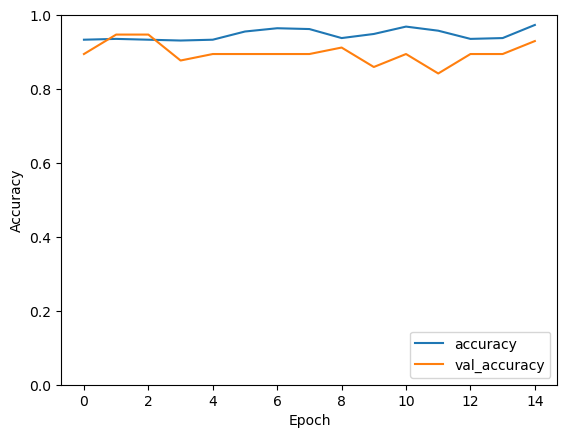

In [23]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [24]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Get predicted labels for test data
y_pred = np.argmax(model.predict(X_test), axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

2/2 [==============================] - 0s 16ms/step - loss: 0.2571 - accuracy: 0.9643
Test accuracy: 0.9642857313156128
2/2 [==============================] - 0s 0s/step
Confusion Matrix:
[[15  0  0  0  0  0]
 [ 0  9  1  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  0  5  1  0]
 [ 0  0  0  0 11  0]
 [ 0  0  0  0  0  5]]


In [25]:
import seaborn as sns

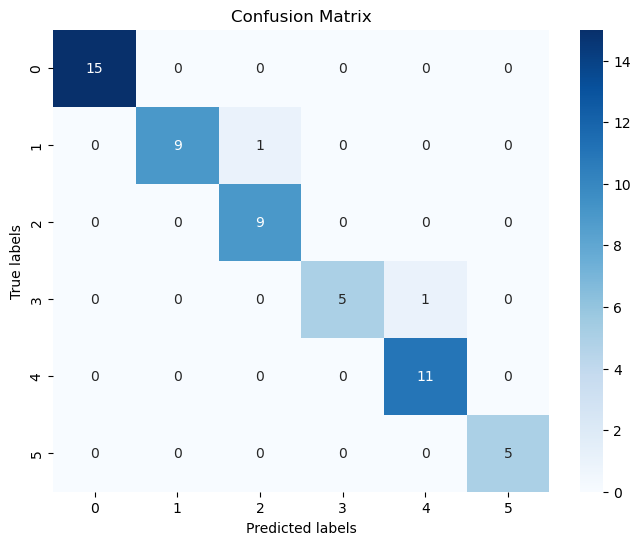

In [27]:
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

In [13]:
# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='macro')
print("F1 Score:", f1)

F1 Score: 0.786734546479674


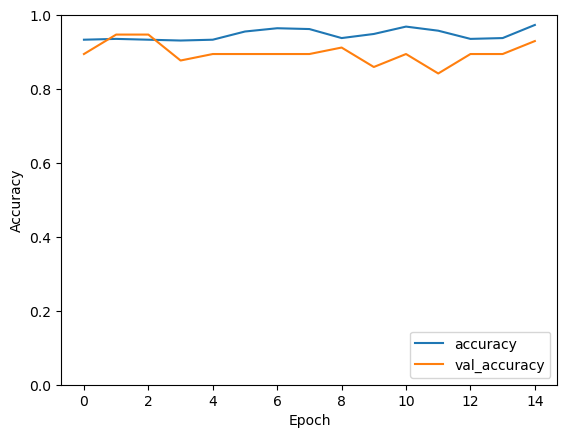

In [28]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.savefig('Acc_Epoch.png')
plt.show()

In [25]:
model.save('model.keras')

In [26]:
print(tf.__version__)

2.15.0


In [27]:
model.save_weights('model_weights.keras')

In [37]:
model.save_weights('model_weights.h5')

In [ ]:
# Function to read data from folders and preprocess using FFT
def preprocess_data(folder_path):
    data = []
    labels = []
    label_to_index = {}  # Dictionary to map label strings to numerical indices
    idx = 0
    for folder_name in os.listdir(folder_path):
        folder = os.path.join(folder_path, folder_name)
        if os.path.isdir(folder):
            for file_name in os.listdir(folder):
                file_path = os.path.join(folder, file_name)
                if file_path.endswith('.csv'):
                    df = pd.read_csv(file_path, header=None)
                    # Preprocess using FFT
                    fft_result = np.fft.fft(df.iloc[:, 1:], axis=0)
                    df_fft = pd.DataFrame(np.abs(fft_result))
                    scaler = StandardScaler()
                    data_scaled = scaler.fit_transform(df_fft)
                    
                    # Handle division by zero or invalid values
                    data_combined = data_scaled.reshape(df_fft.shape[0], -1)
                    nan_mask = np.isnan(data_combined)  # Check for NaN values
                    inf_mask = np.isinf(data_combined)  # Check for infinity values
                    zero_std_mask = (scaler.scale_ == 0)  # Check for zero standard deviation

                    # Set NaN, infinity, and zero standard deviation values to 0
                    data_scaled[nan_mask] = 0
                    data_scaled[inf_mask] = 0
                    data_scaled[:, zero_std_mask] = 0
                    
                    data_scaled_reshaped = data_scaled.reshape(df_fft.shape)
                    
                    data.append(data_scaled_reshaped)
                    
                    # Assign numerical index to the label
                    if folder_name not in label_to_index:
                        label_to_index[folder_name] = idx
                        idx += 1
                    labels.append(label_to_index[folder_name])
    if not data:
        raise ValueError("No data loaded. Check the folder path or data format.")
    return np.array(data), np.array(labels)

In [28]:
def preprocess_data(file_path):
    data = []
    df = pd.read_csv(file_path, header=None)
    # Preprocess using FFT
    fft_result = np.fft.fft(df.iloc[:, 1:], axis=0)
    df_fft = pd.DataFrame(np.abs(fft_result))
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df_fft)
    data_combined = data_scaled.reshape(df_fft.shape[0], -1)
    nan_mask = np.isnan(data_combined)  # Check for NaN values
    inf_mask = np.isinf(data_combined)  # Check for infinity values
    zero_std_mask = (scaler.scale_ == 0)  # Check for zero standard deviation
    
    # Set NaN, infinity, and zero standard deviation values to 0
    data_scaled[nan_mask] = 0
    data_scaled[inf_mask] = 0
    data_scaled[:, zero_std_mask] = 0
    data_scaled_reshaped = data_scaled.reshape(df_fft.shape)
    data.append(data_scaled_reshaped)
    if not data:
        raise ValueError("No data loaded. Check the file path or data format.")
    return np.array(data)

In [47]:
data = preprocess_data("C:/Users/adilm/OneDrive/Desktop/NEW FYP/Data/think_right/data0.csv")

# Reshape data to combine samples and channels
#data_combined = data.reshape(data.shape[0], -1)  # Combine all channels into one dimension
#print(data_combined)
# Normalize the data
#scaler = StandardScaler()
#data_scaled = scaler.fit_transform(data_combined)
print(data_scaled)
# Handle division by zero or invalid values
#nan_mask = np.isnan(data_scaled)  # Check for NaN values
#inf_mask = np.isinf(data_scaled)  # Check for infinity values
#zero_std_mask = (scaler.scale_ == 0)  # Check for zero standard deviation

# Set NaN, infinity, and zero standard deviation values to 0
#data_scaled[nan_mask] = 0
#data_scaled[inf_mask] = 0
#data_scaled[:, zero_std_mask] = 0

# Reshape data back to original shape
#data_scaled_reshaped = data_scaled.reshape(data.shape)

predictions = model.predict(data)
print(predictions)
predicted_class = np.argmax(predictions[0])
print("Predicted class:", predicted_class)

[[0. 0. 0. ... 0. 0. 0.]]
1/1 [==============================] - 0s 31ms/step
[[2.3776678e-05 2.0041603e-01 7.8713036e-01 5.5482718e-07 2.1174969e-06
  1.2427136e-02]]
Predicted class: 2


In [31]:
mean = np.mean(data_scaled_reshaped)
variance = np.var(data_scaled_reshaped)

print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(data_combined.shape)

Mean: 0.0
Variance: 0.0
(1, 2000)


In [156]:
print(data_scaled)


[[0. 0. 0. ... 0. 0. 0.]]


In [157]:
X_test.shape

(56, 500, 4)

In [158]:
print(data_combined.shape)

(1, 2000)


In [160]:
data_scaled_reshaped.shape

(1, 500, 4)